In [7]:
!pwd
!export PYTHONPATH=$PYTHONPATH:$(pwd)/evidential-learning-pytorch

import sys
print(sys.path)
sys.path.append('/work/DRO-EDL/1d/evidential-learning-pytorch')

from tqdm import tqdm
from scipy.stats import norm

import numpy as np
from scipy.stats import norm, invgamma

import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.integrate import dblquad

import torch

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from edl_pytorch import NormalInvGamma, evidential_regression

import torch.optim as optim
from IPython.display import clear_output


/work/DRO-EDL/2d
['/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/opencda/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/work/DRO-EDL/1d/evidential-learning-pytorch']


In [8]:
def cart2polar(x,y):
    r = (x**2 + y**2)**(1/2)
    theta = np.arccos(x/r)
    return r , theta

def polar2cart(r,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y

In [9]:
model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 1),
)
model.load_state_dict(torch.load(f'uncertain_weights/{10}.pth'))

<All keys matched successfully>

tensor(10.0716) tensor(0.2068) tensor(1.0009) tensor(0.0886)
tensor(9.9052) tensor(0.7773) tensor(1.2424) tensor(0.4126)
tensor(10.0847) tensor(0.2131) tensor(1.0011) tensor(0.0956)


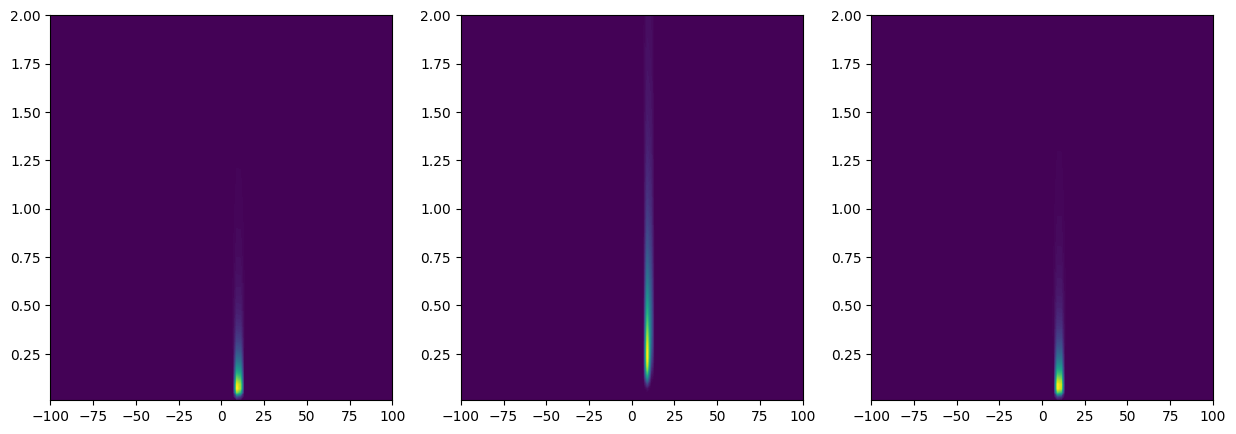

In [10]:
def nig_joint_pdf(mu, sigma2, mu_0, lambda_, alpha, beta):
    # Normal part (mean = mu, variance = sigma2)
    norm_pdf = norm.pdf(mu, mu_0, np.sqrt(sigma2 / lambda_))
    
    # Inverse gamma part (variance = sigma2)
    invgamma_pdf = invgamma.pdf(sigma2, alpha, scale=beta)
    
    return norm_pdf * invgamma_pdf

# CDF에 해당하는 등고선 계산
def calculate_cdf_contour_level(pdf_values, target_cdf):
    # 확률밀도함수 값들을 1D로 변환한 후 정렬
    sorted_pdf = np.sort(pdf_values.flatten())[::-1]
    cumulative_sum = np.cumsum(sorted_pdf)
    cumulative_sum /= cumulative_sum[-1]  # 누적 합을 0~1 사이의 값으로 정규화
    
    # CDF에 해당하는 값을 찾기
    contour_value = sorted_pdf[np.searchsorted(cumulative_sum, target_cdf)]
    return contour_value

data = [-50, 0, 50]

mu_values = np.linspace(-100, 100, 100)
sigma2_values = np.linspace(0.01, 2, 100)
fig, ax = plt.subplots(1, len(data), figsize=(5*len(data),5))

for fig_idx, x in enumerate(data):
    with torch.no_grad():
        pred = model(torch.tensor(cart2polar(x,10), dtype=torch.float))
    
    mu_0, lambda_, alpha, beta = (d.squeeze() for d in pred)
    print(mu_0, lambda_, alpha, beta)
    
    # 그리드를 만들어 결합 확률 밀도를 계산
    mu_grid, sigma2_grid = np.meshgrid(mu_values, sigma2_values)
    std_pdf_values = nig_joint_pdf(mu_grid, sigma2_grid, mu_0, lambda_, alpha, beta)
    
    # 입력받은 CDF 값에 해당하는 등고선 값을 계산
    # contour_level = calculate_cdf_contour_level(std_pdf_values, target_cdf)
    ax[fig_idx].contourf(mu_grid, sigma2_grid, std_pdf_values, levels=np.linspace(0, std_pdf_values.max(), 100), cmap='viridis')
plt.show()

In [11]:
import pickle

with open('a_memory.pickle', 'rb') as fr:
    a_memory = pickle.load(fr)

FileNotFoundError: [Errno 2] No such file or directory: 'a_memory.pickle'

In [12]:
from matplotlib.gridspec import GridSpec

epsilon = 0.9

Output()

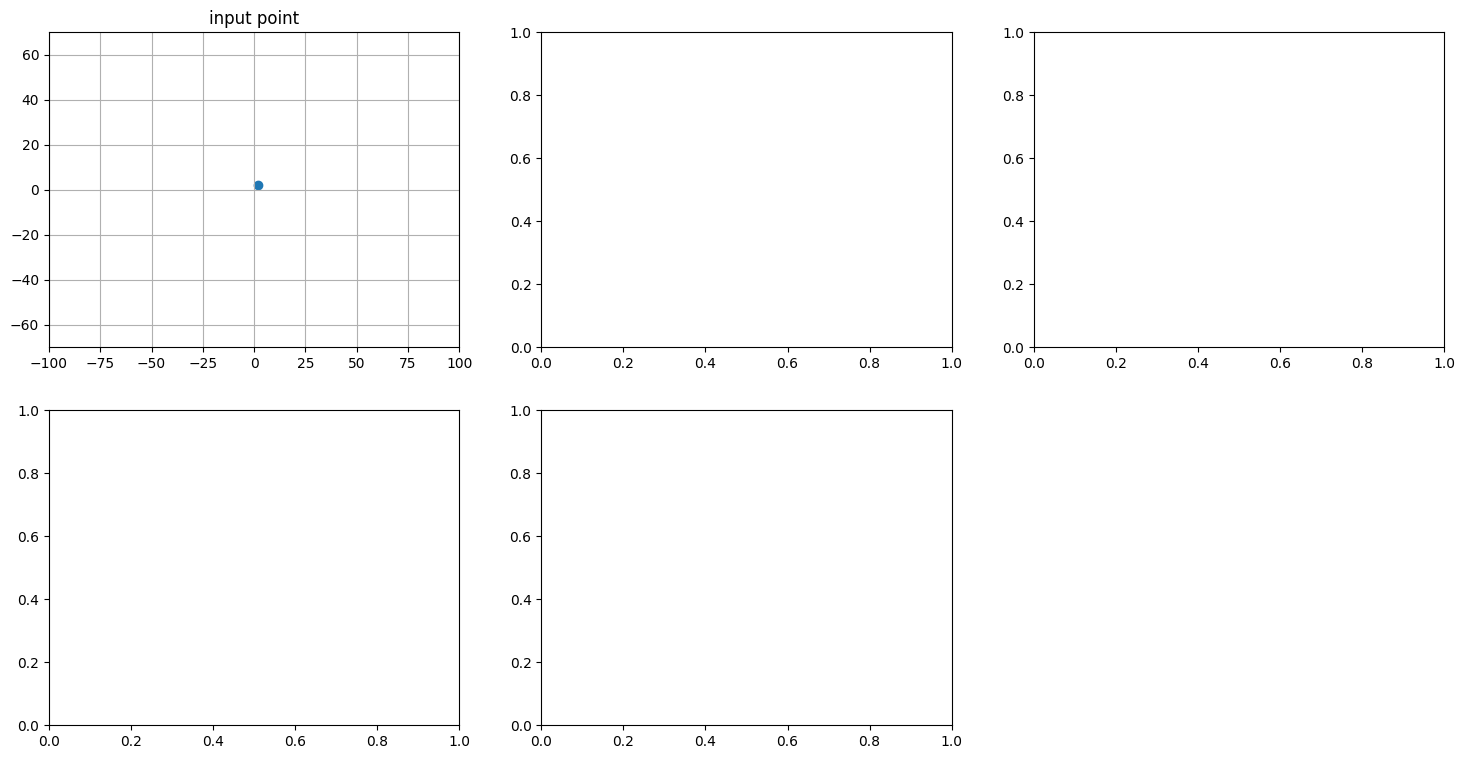

In [13]:
X_RANGE = [-100, 100]
Y_RANGE = [-70, 70]
mu_values = np.linspace(-100, 100, 100)
sigma2_values = np.linspace(0.01, 1, 100)
def update(x, y):
    # 그리드 스펙 설정
    gs = GridSpec(2, 3)
    # 이미지 사이즈 설정
    fig = plt.figure(figsize=(18, 9))
    
    # 크기와 위치가 다른 서브플롯 생성
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 0])
    ax5 = fig.add_subplot(gs[1, 1])

    # 1. input point
    ax1.scatter(x,y)
    ax1.set_xlim(X_RANGE[0], X_RANGE[1])
    ax1.set_ylim(Y_RANGE[0], Y_RANGE[1])
    ax1.grid(True)
    ax1.set_title('input point')

    # 2. certain model prediction
    model.load_state_dict(torch.load(f'certain_weights/{99}.pth', weights_only=True))
    with torch.no_grad():
        pred = model(torch.tensor(cart2polar(x,y), dtype=torch.float))
    
    mu_0, lambda_, alpha, beta = (d.squeeze() for d in pred)
    print(mu_0, lambda_, alpha, beta, torch.sqrt(beta / (lambda_ * (alpha - 1))))
    
    # 그리드를 만들어 결합 확률 밀도를 계산
    mu_grid, sigma2_grid = np.meshgrid(mu_values, sigma2_values)
    std_pdf_values = nig_joint_pdf(mu_grid, sigma2_grid, mu_0, lambda_, alpha, beta)
    
    # 입력받은 CDF 값에 해당하는 등고선 값을 계산
    ax2.contourf(mu_grid, sigma2_grid, std_pdf_values, levels=np.linspace(0, std_pdf_values.max(), 100), cmap='viridis')
    zx, zy = a_memory[float(f'{alpha:.02f}')]
    certain_mu, certain_sigma2 = mu_0 - zx / np.sqrt(lambda_/beta), zy * beta
    ax2.scatter(certain_mu, certain_sigma2)
    ax2.set_title('Certain model prediction\n({:.04f}, {:.04f})'.format(certain_mu, certain_sigma2))

    
    # 3. Uncertain model prediction
    model.load_state_dict(torch.load(f'uncertain_weights/{20}.pth', weights_only=True))
    
    with torch.no_grad():
        pred = model(torch.tensor(cart2polar(x,y), dtype=torch.float))
    
    mu_0, lambda_, alpha, beta = (d.squeeze() for d in pred)
    print(mu_0, lambda_, alpha, beta, torch.sqrt(beta / (lambda_ * (alpha - 1))))
    
    # 그리드를 만들어 결합 확률 밀도를 계산
    mu_grid, sigma2_grid = np.meshgrid(mu_values, sigma2_values)
    std_pdf_values = nig_joint_pdf(mu_grid, sigma2_grid, mu_0, lambda_, alpha, beta)
    
    # 입력받은 CDF 값에 해당하는 등고선 값을 계산
    ax3.contourf(mu_grid, sigma2_grid, std_pdf_values, levels=np.linspace(0, std_pdf_values.max(), 100), cmap='viridis')
    zx, zy = a_memory[float(f'{alpha:.02f}')]
    uncertain_mu, uncertain_sigma2 = mu_0 - zx / np.sqrt(lambda_/beta), zy * beta
    ax3.scatter(uncertain_mu, uncertain_sigma2)
    ax3.set_title('Uncertain model prediction')
    ax3.set_title('Unertain model prediction\n({:.04f}, {:.04f})'.format(uncertain_mu, uncertain_sigma2))


    # 4. Distribution
    kappa = norm.pdf(norm.ppf(epsilon))/(1-epsilon)
    
    l = np.linspace(X_RANGE[0], X_RANGE[1], 1000)
    certain_DR_EDL_CVaR = certain_mu + kappa * np.sqrt(certain_sigma2)
    ax4.plot(l, norm.pdf(l, certain_mu, certain_sigma2), label='certain')
    ax4.axvline(certain_DR_EDL_CVaR, color='brown', linestyle='--', label=f'DRO-EDL-CVaR (epsilon={epsilon*100}%) = {certain_DR_EDL_CVaR:.2f}')

    uncertain_DR_EDL_CVaR = uncertain_mu + kappa * np.sqrt(uncertain_sigma2)
    ax4.plot(l, norm.pdf(l, uncertain_mu, uncertain_sigma2), label='uncertain')
    ax4.axvline(uncertain_DR_EDL_CVaR, color='brown', linestyle='--', label=f'DRO-EDL-CVaR (epsilon={epsilon*100}%) = {uncertain_DR_EDL_CVaR:.2f}')
    ax4.set_xlim(X_RANGE[0], X_RANGE[1])
    ax4.legend()
    ax4.grid(True)
    ax4.set_xlabel("Obstacle Position")
    ax4.set_ylabel("Probability")
    ax4.set_title('Prob. distribution, ego: 0')


    # 5. Boundary


    labels = ['certain', 'uncertain']
    for i, risk in enumerate([certain_DR_EDL_CVaR, uncertain_DR_EDL_CVaR]):
        ax5.plot(l, -risk+l, label=labels[i])
    ax5.axhline(0, color='black')

    ax5.grid(True, which='both')
    ax5.set_xlabel("Ego Position")
    ax5.set_ylabel("Cost")
    ax5.set_xlim(X_RANGE[0], X_RANGE[1])
    ax5.set_ylim(Y_RANGE[0], Y_RANGE[1])
    ax5.legend()
        
    
    plt.show()
import ipywidgets as widgets

x_slider = widgets.FloatSlider(value=2, min=X_RANGE[0], max=X_RANGE[1], step=0.1, description='x')
y_slider = widgets.FloatSlider(value=2, min=Y_RANGE[0], max=Y_RANGE[1], step=0.1, description='y')
ui = widgets.VBox([x_slider, y_slider])
out = widgets.interactive_output(update, {
    'x': x_slider, 
    'y': y_slider, 
})

display(ui, out)

In [14]:
epsilon = 0.999

kappa = norm.pdf(norm.ppf(epsilon))/(1-epsilon)
print(kappa)

3.367090077063992


In [15]:
a_memory[3.7233]

NameError: name 'a_memory' is not defined

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

epsilon = 0.9

X_RANGE = [-70, 70]
Y_RANGE = [-70, 70]
x_values = np.linspace(*X_RANGE, 140)
y_values = np.linspace(*Y_RANGE, 140)
x_grid, y_grid = np.meshgrid(x_values, y_values)

kappa = norm.pdf(norm.ppf(epsilon))/(1-epsilon)

model.load_state_dict(torch.load(f'uncertain_weights/{99}.pth', weights_only=True))
with torch.no_grad():
    pred = model(torch.tensor(cart2polar(x_grid,y_grid), dtype=torch.float).flatten(1).T)
    mu_0, lambda_, alpha, beta = (d.squeeze() for d in pred)
    z = torch.tensor([a_memory[float(f'{a+0.01:.02f}')] for a in alpha])
    zx, zy = z[:,0], z[:,1]
    certain_mu, certain_sigma2 = mu_0 - zx / np.sqrt(lambda_/beta), zy * beta
    certain_DR_EDL_CVaR = certain_mu + kappa * np.sqrt(certain_sigma2)


model.load_state_dict(torch.load(f'uncertain_weights/{20}.pth', weights_only=True))
with torch.no_grad():
    pred = model(torch.tensor(cart2polar(x_grid,y_grid), dtype=torch.float).flatten(1).T)
    mu_0, lambda_, alpha, beta = (d.squeeze() for d in pred)
    z = torch.tensor([a_memory[float(f'{a+0.01:.02f}')] for a in alpha])
    zx, zy = z[:,0], z[:,1]
    uncertain_mu, uncertain_sigma2 = mu_0 - zx / np.sqrt(lambda_/beta), zy * beta
    uncertain_DR_EDL_CVaR = uncertain_mu - kappa * np.sqrt(uncertain_sigma2)

# data = torch.tensor(x_grid) - certain_DR_EDL_CVaR.reshape(140, 140)
# cmap = plt.get_cmap('coolwarm')  # 또는 'bwr', 'seismic' 등의 색상 팔레트
# color_norm = CenteredNorm(vcenter=0)  # 0을 중심으로 설정

# 히트맵 그리기
# plt.figure(figsize=(8, 6))
# plt.imshow(data, cmap=cmap, norm=color_norm, aspect='auto', origin='lower')
# plt.colorbar(label="Value")
# plt.clim(-10, 10)
# plt.title("X - Certain | Heatmap with Positive and Negative Values")
# plt.show()
# ''''''

data = torch.tensor(x_grid) - uncertain_DR_EDL_CVaR.reshape(140, 140)
cmap = plt.get_cmap('coolwarm')  # 또는 'bwr', 'seismic' 등의 색상 팔레트
color_norm = CenteredNorm(vcenter=0)  # 0을 중심으로 설정

# 히트맵 그리기
plt.figure(figsize=(8, 6))
plt.matshow(data, cmap=cmap, norm=color_norm, aspect='auto', origin='lower')
plt.colorbar(label="Value")
plt.clim(-10, 10)
plt.title("X - Uncertain | Heatmap with Positive and Negative Values")
plt.show()

# data = uncertain_DR_EDL_CVaR.reshape(140, 140) - certain_DR_EDL_CVaR.reshape(140, 140)
# cmap = plt.get_cmap('coolwarm')  # 또는 'bwr', 'seismic' 등의 색상 팔레트
# color_norm = CenteredNorm(vcenter=0)  # 0을 중심으로 설정

# # 히트맵 그리기
# plt.figure(figsize=(8, 6))
# plt.imshow(data, cmap=cmap, norm=color_norm, aspect='auto', origin='lower')
# plt.colorbar(label="Value")
# plt.clim(-10, 10)
# plt.title("Uncertain - Certain | Heatmap with Positive and Negative Values")
# plt.show()

/tmp/ipykernel_9351/887520505.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  pred = model(torch.tensor(cart2polar(x_grid,y_grid), dtype=torch.float).flatten(1).T)


NameError: name 'a_memory' is not defined

In [28]:
data.min(), data.max()

(tensor(-0.4754, dtype=torch.float64), tensor(327.3511, dtype=torch.float64))

# Trained model comparison

In [4]:
test_data = torch.concat([torch.linspace(-200, 200, 1000).unsqueeze(-1), 10*torch.ones(1000).unsqueeze(-1)], axis=1)
y_test = test_data[:,0].unsqueeze(-1)

In [19]:



def update(certain_ep, uncertain_ep):
    x_test = torch.tensor([cart2polar(x,y) for x,y in test_data])


    fig, ax = plt.subplots(1,2, figsize=(10, 3), dpi=200)

    # 1. Certain
    model.load_state_dict(torch.load(f'uncertain_weights/{certain_ep}.pth', weights_only=True))
    
    with torch.no_grad():
        pred = model(x_test)
    
    mu, v, alpha, beta = (d.squeeze() for d in pred)
    x_test = x_test.squeeze()
    ep_var = torch.sqrt(beta / (v * (alpha - 1)))
    al_var = torch.sqrt(beta / (alpha - 1))
    
    x_test_data = [polar2cart(x,y)[0] for x,y in x_test]
    ax[0].plot(x_test_data, y_test, c="k", label="True")
    ax[0].plot(x_test_data, mu, c="tab:blue", ls="--", label="Pred")
    for std in range(4):
        ax[0].fill_between(
            x_test_data,
            (mu - std * ep_var),
            (mu + std * ep_var),
            alpha=0.2,
            facecolor="tab:blue",
            label="Unc." if std == 0 else None,
        )
    ax[0].set_ylim(-200, 200)
    ax[0].legend(loc="upper left")
    ax[0].set_title(f'Certain model | epoch: {certain_ep}')

    # 2. Uncertain
    
    model.load_state_dict(torch.load(f'uncertain_weights/{uncertain_ep}.pth', weights_only=True))
    
    with torch.no_grad():
        pred = model(x_test)
    
    mu, v, alpha, beta = (d.squeeze() for d in pred)
    x_test = x_test.squeeze()
    ep_var = torch.sqrt(beta / (v * (alpha - 1)))
    al_var = torch.sqrt(beta / (alpha - 1))
    
    x_test_data = [polar2cart(x,y)[0] for x,y in x_test]
    ax[1].plot(x_test_data, y_test, c="k", label="True")
    ax[1].plot(x_test_data, mu, c="tab:blue", ls="--", label="Pred")
    for std in range(4):
        ax[1].fill_between(
            x_test_data,
            (mu - std * ep_var),
            (mu + std * ep_var),
            alpha=0.2,
            facecolor="tab:blue",
            label="Unc." if std == 0 else None,
        )
    ax[1].set_ylim(-100, 100)
    ax[1].legend(loc="upper left")
    ax[1].set_title(f'Uncertain model | epoch: {uncertain_ep}')


    
    plt.show()
    
certain_ep = widgets.IntSlider(value=0, min=0, max=99, step=1, description='certain_epoch')
uncertain_ep = widgets.IntSlider(value=0, min=0, max=99, step=1, description='uncertain_epoch')
ui = widgets.VBox([certain_ep, uncertain_ep])
out = widgets.interactive_output(update, {
    'certain_ep': certain_ep, 
    'uncertain_ep': uncertain_ep, 
})

display(ui, out)

Output()

In [6]:
X_RANGE = [-70, 70]
Y_RANGE = [-70, 70]
mu_values = np.linspace(-100, 100, 100)
sigma2_values = np.linspace(0.01, 0.5, 100)
def update(x, y):
    # 그리드 스펙 설정
    gs = GridSpec(2, 3)
    # 이미지 사이즈 설정
    fig = plt.figure(figsize=(18, 9))
    
    # 크기와 위치가 다른 서브플롯 생성
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 0])
    ax5 = fig.add_subplot(gs[1, 1])

    # 1. input point
    ax1.scatter(x,y)
    ax1.set_xlim(X_RANGE[0], X_RANGE[1])
    ax1.set_ylim(Y_RANGE[0], Y_RANGE[1])
    ax1.grid(True)
    ax1.set_title('input point')

    # 2. certain model prediction
    model.load_state_dict(torch.load(f'certain_weights/{99}.pth', weights_only=True))
    with torch.no_grad():
        pred = model(torch.tensor(cart2polar(x,y), dtype=torch.float))
    
    mu_0, lambda_, alpha, beta = (d.squeeze() for d in pred)
    print(mu_0, lambda_, alpha, beta, torch.sqrt(beta / (lambda_ * (alpha - 1))))
    
    # 그리드를 만들어 결합 확률 밀도를 계산
    mu_grid, sigma2_grid = np.meshgrid(mu_values, sigma2_values)
    std_pdf_values = nig_joint_pdf(mu_grid, sigma2_grid, mu_0, lambda_, alpha, beta)
    
    # 입력받은 CDF 값에 해당하는 등고선 값을 계산
    ax2.contourf(mu_grid, sigma2_grid, std_pdf_values, levels=np.linspace(0, std_pdf_values.max(), 100), cmap='viridis')
    zx, zy = a_memory[float(f'{alpha:.02f}')]
    certain_mu, certain_sigma2 = mu_0 - zx / np.sqrt(lambda_/beta), zy * beta
    ax2.scatter(certain_mu, certain_sigma2)
    ax2.set_title('Certain model prediction\n({:.04f}, {:.04f})'.format(certain_mu, certain_sigma2))

    
    # 3. Uncertain model prediction
    model.load_state_dict(torch.load(f'uncertain_weights/{19}.pth', weights_only=True))
    
    with torch.no_grad():
        pred = model(torch.tensor(cart2polar(x,y), dtype=torch.float))
    
    mu_0, lambda_, alpha, beta = (d.squeeze() for d in pred)
    print(mu_0, lambda_, alpha, beta, torch.sqrt(beta / (lambda_ * (alpha - 1))))
    
    # 그리드를 만들어 결합 확률 밀도를 계산
    mu_grid, sigma2_grid = np.meshgrid(mu_values, sigma2_values)
    std_pdf_values = nig_joint_pdf(mu_grid, sigma2_grid, mu_0, lambda_, alpha, beta)
    
    # 입력받은 CDF 값에 해당하는 등고선 값을 계산
    ax3.contourf(mu_grid, sigma2_grid, std_pdf_values, levels=np.linspace(0, std_pdf_values.max(), 100), cmap='viridis')
    zx, zy = a_memory[float(f'{alpha:.02f}')]
    uncertain_mu, uncertain_sigma2 = mu_0 - zx / np.sqrt(lambda_/beta), zy * beta
    ax3.scatter(uncertain_mu, uncertain_sigma2)
    ax3.set_title('Uncertain model prediction')
    ax3.set_title('Unertain model prediction\n({:.04f}, {:.04f})'.format(uncertain_mu, uncertain_sigma2))


    # 4. Distribution
    kappa = norm.pdf(norm.ppf(epsilon))/(1-epsilon)
    
    l = np.linspace(X_RANGE[0], X_RANGE[1], 1000)
    certain_DR_EDL_CVaR = certain_mu + kappa * np.sqrt(certain_sigma2)
    ax4.plot(l, norm.pdf(l, certain_mu, certain_sigma2), label='certain')
    ax4.axvline(certain_DR_EDL_CVaR, color='brown', linestyle='--', label=f'DRO-EDL-CVaR (epsilon={epsilon*100}%) = {certain_DR_EDL_CVaR:.2f}')

    uncertain_DR_EDL_CVaR = uncertain_mu + kappa * np.sqrt(uncertain_sigma2)
    ax4.plot(l, norm.pdf(l, uncertain_mu, uncertain_sigma2), label='uncertain')
    ax4.axvline(uncertain_DR_EDL_CVaR, color='brown', linestyle='--', label=f'DRO-EDL-CVaR (epsilon={epsilon*100}%) = {uncertain_DR_EDL_CVaR:.2f}')
    ax4.set_xlim(X_RANGE[0], X_RANGE[1])
    ax4.legend()
    ax4.grid(True)
    ax4.set_xlabel("Obstacle Position")
    ax4.set_ylabel("Probability")
    ax4.set_title('Prob. distribution, ego: 0')


    # 5. Boundary


    labels = ['certain', 'uncertain']
    for i, risk in enumerate([certain_DR_EDL_CVaR, uncertain_DR_EDL_CVaR]):
        ax5.plot(l, -risk+l, label=labels[i])
    ax5.axhline(0, color='black')

    ax5.grid(True, which='both')
    ax5.set_xlabel("Ego Position")
    ax5.set_ylabel("Cost")
    ax5.set_xlim(X_RANGE[0], X_RANGE[1])
    ax5.set_ylim(Y_RANGE[0], Y_RANGE[1])
    ax5.legend()
        
    
    plt.show()
import ipywidgets as widgets

x_slider = widgets.FloatSlider(value=2, min=X_RANGE[0], max=X_RANGE[1], step=1, description='x')
y_slider = widgets.FloatSlider(value=2, min=Y_RANGE[0], max=Y_RANGE[1], step=1, description='y')
ui = widgets.VBox([x_slider, y_slider])
out = widgets.interactive_output(update, {
    'x': x_slider, 
    'y': y_slider, 
})

display(ui, out)

Output()